# Trying to create an SEU model using point processes


In [52]:
# set up autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import dblquad

## Model number 1
A lot of the calculations in this model are wrong, but this is a proof of concept

spaces are
$$
S=\mathbb{R}_+ \times \mathbb{R}_+ \times \mathbb{R}_+^2,\quad S\supseteq B=T\times E\times X
$$

intensity function
$$
\phi(t,\epsilon,x): S\rightarrow \mathbb{R},\quad t\in T\subset\mathbb{R}_+,\ \epsilon\in E\subseteq\mathbb{R}_+,\ x\in X\subseteq\mathbb{R}_+^2
$$

Intensity measure and density are implicitly defined form flux/intensity function. We then get $Y$ as a Poisson process on $S$.

Thinning
$$
Y_{thin}=\left\{ y\in Y\ \vert\ p(y)\geq R_u\sim\text{Unif}[0,1] \right\}, \quad p(t,\epsilon,x)=\epsilon\sigma A_{die}.
$$
with sigma being cross-section and $A_{die}$ being area of die.

In [54]:
# Setting parameters of the model
# ======================================================================================
N = 100
MIN_N_FOR_SIM = 1000
OVERRIDE_FOR_SIM = True

# Specify time dimension
T0 = 0
T1 = 10

# Specify energy dimension (MeV) for LET
E0 = 0
E1 = 20

# Specify spatial dimension in x and y (cm)
X0 = 0
X1 = 2
Y0 = 0
Y1 = 2

# Generate spatial samplings
T = np.linspace(T0, T1, N)
E = np.linspace(E0, E1, N)
X = np.linspace(X0, X1, N)
Y = np.linspace(Y0, Y1, N)

/tmp/ipykernel_228397/2635862196.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


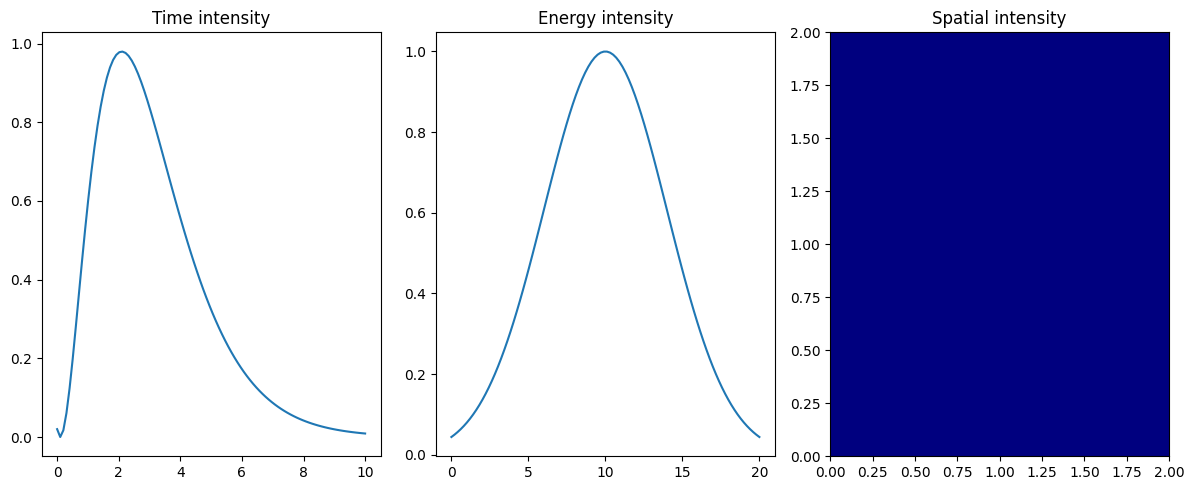

In [55]:
# Define the flux
# ======================================================================================
def _time_intensity(t, a=1):
    res = np.exp(-a*t) * (t-0.1)**2 * 2
    
    return np.nan_to_num(res)

def _energy_intensity(e, a=1):
    # bell curve with mean 10, and std 4
    res = np.exp(-(e-10)**2/(2*4**2))
    
    # res = (np.exp(a*(-10)) * (0.1-(e-10))**2 * 2) + 0.2
    
    return np.nan_to_num(res)

def _spatial_intensity(x, y, a=1):
    # return np.exp(-(x-1)**2/(2*0.2**2)) * np.exp(-(y-1)**2/(2*0.2**2))
    res = a
    
    return np.nan_to_num(res)

def flux(t, e, x, y):
    res = _time_intensity(t) * _energy_intensity(e) * _spatial_intensity(x, y)
    
    return np.nan_to_num(res)

_spatial = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        _spatial[i, j] = _spatial_intensity(X[i], Y[j])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

ax[0].plot(T, _time_intensity(T))
ax[1].plot(E, _energy_intensity(E))
ax[2].imshow(_spatial, extent=[X0, X1, Y0, Y1], aspect='auto', cmap='jet')

ax[0].set_title('Time intensity')
ax[1].set_title('Energy intensity')
ax[2].set_title('Spatial intensity')

fig.tight_layout()
fig.show()

/tmp/ipykernel_228397/3945713790.py:6: RuntimeWarning: invalid value encountered in power
  exp = np.exp(-((e-E_0)/w)**s)
/tmp/ipykernel_228397/3945713790.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


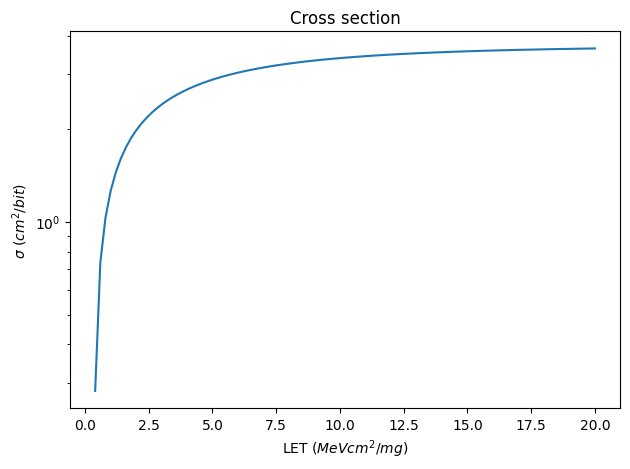

In [56]:
# Define the cross section
# ======================================================================================
def sigma(e, sigma_sat=3.72, E_0=0.35, w=2.53, s=0.66):
    # sigma_sat is bigger in https://cds.cern.ch/record/2196928/files/Sub-LET%20Threshold%20SEE%20Cross%20Section%20Dependency%20with%20Ion%20Energy.pdf
    # see fig 3
    exp = np.exp(-((e-E_0)/w)**s)
    return sigma_sat * (1 - exp)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(E, sigma(E))

ax.set_title('Cross section')
ax.set_xlabel(r'LET $(MeVcm^2/mg)$')
ax.set_ylabel(r'$\sigma$ $(cm^2/bit)$')
ax.set_yscale('log')
fig.tight_layout()
fig.show()

/tmp/ipykernel_228397/3945713790.py:6: RuntimeWarning: invalid value encountered in power
  exp = np.exp(-((e-E_0)/w)**s)
/tmp/ipykernel_228397/4025774955.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_228397/3945713790.py:6: RuntimeWarning: invalid value encountered in scalar power
  exp = np.exp(-((e-E_0)/w)**s)
/tmp/ipykernel_228397/4025774955.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


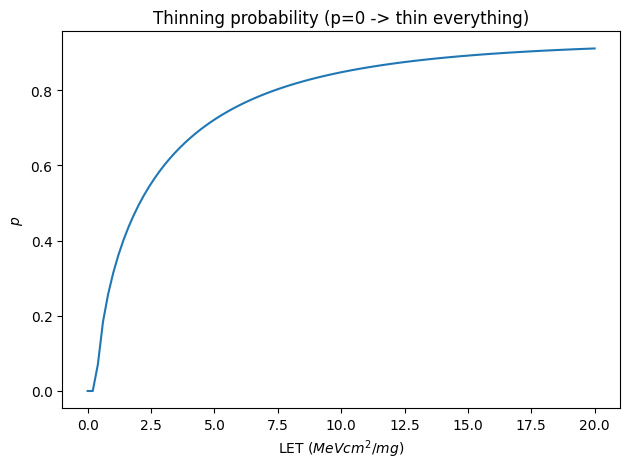

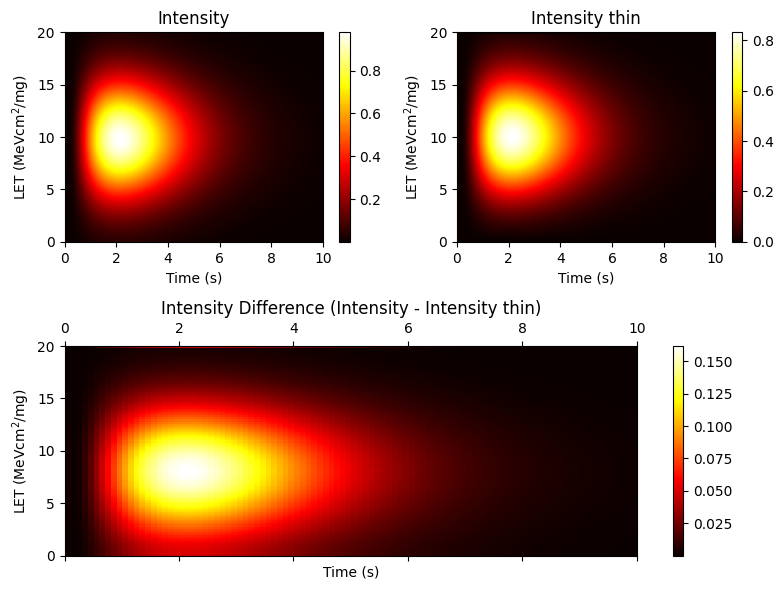

In [57]:
# Define thinning
# ======================================================================================

def p_thin(t, e, x, y):
    A = (X.max() - X.min()) * (Y.max() - Y.min())
    p_0 = sigma(e) / A
    
    return np.nan_to_num(p_0)

y = p_thin(0, E, 0, 0)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(E, y)
ax.set_title('Thinning probability (p=0 -> thin everything)')
ax.set_xlabel(r'LET $(MeVcm^2/mg)$')
ax.set_ylabel(r'$p$')
fig.tight_layout()
fig.show()

def flux_thin(t, e, x, y):
    return flux(t, e, x, y) * p_thin(t, e, x, y)

_tmp_fluence_thin = lambda t, e : flux_thin(e, t, X[0], Y[0])
fluence_thin = dblquad(_tmp_fluence_thin, T0, T1, lambda x: E0, lambda x: E1)[0]

def density_thin(t, e, x, y):
    return flux_thin(t, e, x, y) / fluence_thin

_tmp_fluence = lambda t, e : flux(e, t, X[0], Y[0])
fluence = dblquad(_tmp_fluence, T0, T1, lambda x: E0, lambda x: E1)[0]

def density(t, e, x, y):
    return flux(t, e, x, y) / fluence

_intens = np.zeros((N, N))
_intens_thin = np.zeros((N, N))
_intens_diff = np.zeros((N, N))
for i, _e in enumerate(E):
    for j, _t in enumerate(T):
        _intens[-i, j] = flux(_t, _e, X[0], Y[0])
        _intens_thin[-i, j] = flux_thin(_t, _e, X[0], Y[0])
_intens_diff = _intens - _intens_thin

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[3, 3], width_ratios=[4, 4])

ax1 = fig.add_subplot(gs[0, 0])
cb1 = ax1.imshow(_intens, extent=[T0, T1, E0, E1], aspect='auto', cmap='hot')
ax1.set_title('Intensity')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('LET (MeVcm$^2$/mg)')

ax2 = fig.add_subplot(gs[0, 1])
cb2 = ax2.imshow(_intens_thin, extent=[T0, T1, E0, E1], aspect='auto', cmap='hot')
ax2.set_title('Intensity thin')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('LET (MeVcm$^2$/mg)')

ax3 = fig.add_subplot(gs[1, :])
cb3 = ax3.matshow(_intens_diff, extent=[T0, T1, E0, E1], aspect='auto', cmap='hot')
ax3.set_title('Intensity Difference (Intensity - Intensity thin)')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('LET (MeVcm$^2$/mg)')

fig.colorbar(cb1, ax=ax1)
fig.colorbar(cb2, ax=ax2)
fig.colorbar(cb3, ax=ax3)

fig.tight_layout()
fig.show()

Expected number of events: 22
Overriding number of events to 1000
otherwise simulation and visualization are not good
Max thinned flux before sim: 0.20455395878561677
p_u > flux_thin_max, need restart
p_u > flux_thin_max, need restart
p_u > flux_thin_max, need restart
p_u > flux_thin_max, need restart
p_u > flux_thin_max, need restart
Max thinned flux after sim: 0.830864730563096
Number of accepted points: 172
Number of rejected points: 828
Rejected 82.80% of points


/tmp/ipykernel_228397/1223823095.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


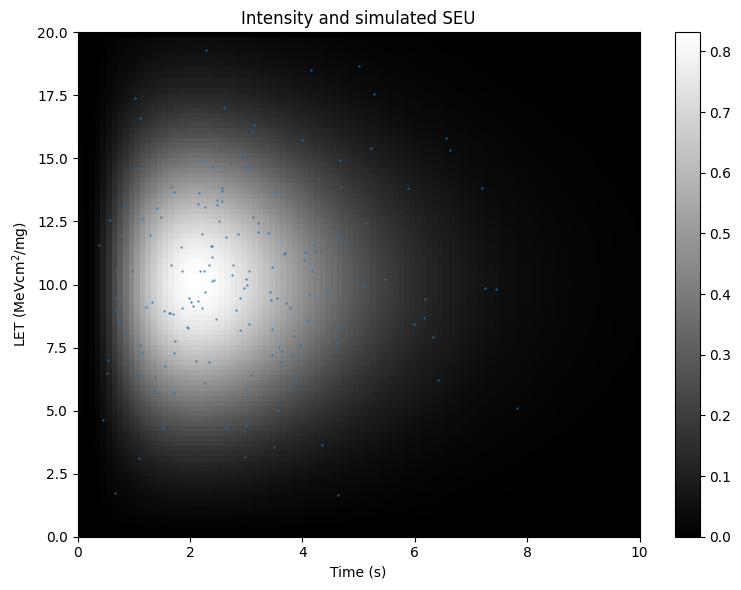

In [58]:
# Simulation of Poisson
# ======================================================================================
n = 0
while n == 0:
    n = np.random.poisson(fluence_thin)
print(f"Expected number of events: {n}")
if OVERRIDE_FOR_SIM and n < MIN_N_FOR_SIM:
    n = MIN_N_FOR_SIM
    print(f"Overriding number of events to {n}")
    print("otherwise simulation and visualization are not good")

time_intens = _time_intensity(T)
max_from_t = np.max(time_intens)
flux_thin_max = 0.20455395878561677  # init_guess (t,e,x,y)=(2,10,1,1), optim by sim
print(f"Max thinned flux before sim: {flux_thin_max}")

should_restart = True
found_new_max = False
curr_max = 0

while should_restart:
    points = list()
    discarded_points = list()
    for i in range(n):
        # generate homogeneous random point
        t = np.random.uniform(T0, T1)
        e = np.random.uniform(E0, E1)
        x = np.random.uniform(X0, X1)
        y = np.random.uniform(Y0, Y1)
        
        # accept or reject
        r_u = np.random.uniform(0, flux_thin_max)
        p_u = flux_thin(t, e, x, y)
        
        if p_u > curr_max:
            curr_max = p_u
        
        if p_u > flux_thin_max:
            print("p_u > flux_thin_max, need restart")
            flux_thin_max = p_u
            should_restart = True
            found_new_max = True
            break
        else:
            should_restart = False

        if p_u >= r_u:
            points.append((t, e))
        else:
            discarded_points.append((t, e))

print(f"Max thinned flux after sim: {flux_thin_max}")

if not found_new_max:
    print(f"Did not find new max for flux. Max is {flux_thin_max}")
    print(f"and curr_max is {curr_max}. Consider if this is realistic")

x, y = zip(*points)

print(f"Number of accepted points: {len(points)}")
print(f"Number of rejected points: {len(discarded_points)}")
print(f"Rejected {100 * (1 - (len(points) / n)):.2f}% of points")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
cb = ax.imshow(_intens_thin, extent=[T0, T1, E0, E1], aspect='auto', cmap='gray')
ax.scatter(x, y, s=0.5, alpha=0.7)
ax.set_title('Intensity and simulated SEU')
ax.set_xlabel("Time (s)")
ax.set_ylabel("LET (MeVcm$^2$/mg)")
fig.colorbar(cb, ax=ax)
fig.tight_layout()
fig.show()